# **Disclaimer:**
This assignment must be completed solely by the members of your group. Sharing of code between groups is strictly prohibited. However, you are allowed to discuss general solution approaches or share publicly available resources with members of other groups. Therefore, clearly indicate which public resources you consulted and/or copied code from. Any plagiarism between groups will result in the initiation of a fraud procedure with the director of education.

# **Introduction**

In this assignment, you will train a Reinforcement Learning (RL) agent to address a Residential Energy Management problem.

The goal is for your agent to control a battery and optimize the electricity costs for a residential household. You will submit your trained agent, which will first be evaluated using an evaluation dataset (different from what you have). Following that, your agent will be deployed in a real-world setting: the [HomeLab](https://idlab.ugent.be/resources/homelab). After deployment, you will receive data detailing the performance of your agent in both environments. Finally, you will write a brief essay analyzing and discussing the results. \
Moreover, we wrote a set of questions / tasks you can fill in the notebook. Each question will contribute to the final grade you will obtain from this assignment.

The task involves managing energy for a residential household equipped with a Photovoltaic (PV) system and an Energy Storage System (ESS), specifically a battery. In the context of the global shift toward decarbonizing energy sources, these types of challenges are becoming increasingly significant. Reinforcement Learning (RL) has proven to be a promising technique for addressing them.

The setup includes a household where residents consume electricity daily, resulting in a unique consumption profile. Electricity costs are based on a dynamic price profile, with prices varying by the hour. When the household generates more energy (from the PV system or battery) than it consumes, the excess will be sold back to the grid, although the selling price is typically much lower than the buying price.

Your objective is to train an RL agent to control the battery and minimize electricity costs. While this might initially seem straightforward (e.g., charge the battery when prices are low and discharge it when prices are high), there are several challenges that complicate the problem:

*   **Uncertainty in household consumption**: Future consumption is difficult to predict. While models based on inhabitants' habits can provide reasonable estimates[1], there is always a stochastic element involved.
*   **Variability in PV production**: PV energy generation depends on weather conditions, adding another layer of unpredictability.
*   **Dynamic price profiles**: Although, for simplicity, we assume a single price profile repeats daily in this assignment, real-world scenarios often involve prices that vary from day to day.
*   **Physical constraints**: The control of the battery and the accuracy of data from the household (such as PV production and overall consumption) are not perfect. While these issues are ignored in the simulation, they will become evident in the real-world results from HomeLab after your agent has been deployed.

Additionally, although not considered in this assignment, more complex setups may include assets like heat pumps or electric vehicle chargers. These cases may require an extended RL framework, potentially involving multi-agent systems.

In the assignment, you will use an agent based on the [PPO](https://arxiv.org/pdf/1707.06347) algorithm. There are some libraries that have already implemented the algorithm, the most famous being [stable-baselines3](https://stable-baselines3.readthedocs.io/en/master/#). However, in this assignment, you will write the algorithm code yourself. To help you with the task, we provide you with most of the code you will need to develop a PPO agent.

\

---

\

[1] e.g., by observing that they usually leave for work from 9:00 AM to 18:00 PM and cook at 19:00 PM, we can obtain a sensible model of the expected consumption

\

---

\


Let's now delve into the assignment details!

# **Support Classes**

In this assignment, we provide the essential code to help you train a PPO agent for a Home Energy Management (HEM) problem. To begin, download the material.zip file available in the course resources. This file contains the necessary code and information to complete the assignment.

After downloading, extract the .py files and upload them into the 'Files' section of this Colab notebook. Next, run the code snippet below, which will import all required external libraries, along with the support classes from the files you just uploaded.

We advise you **not** to change the code we provided you in such files. Any changes in those files that hinder our evaluation of your agents might result in your submission receiving a lower grade.

**N.B:** For training the neural networks used in the PPO algorithm, we require that you use the PyTorch library included in the provided files. Using other deep learning libraries (e.g., TensorFlow) could cause compatibility issues when evaluating your agent.

If you require additional standard Python packages for your work, feel free to import them in the following cell. (by standard Python packages we consider the ones included in the Google colab environment. Avoid using any 'pip install' call in this notebook) \
In case you want to download the notebook and run it locally, you can recreate the colab environment by installing the same versions in your local machine. The list of packages' versions can be seen through the command `!pip freeze` executed below.

In [ ]:
import sys
import numpy as np
import torch
from torch import nn
from torch.distributions import MultivariateNormal
import matplotlib.pyplot as plt
import pickle

sys.path.insert(0, 'Environment.py')
sys.path.insert(0, 'nn_utils.py')

from Environment import BaseEnvironment
from nn_utils import GenericNeuralNetwork



# Extra imports:
# import ...

In [ ]:
#!pip freeze

# **Environment**

Now that you imported the classes from the files we provided you, you can start building an RL framework. RL agents learn how to obtain optimal actions by interacting with an environment, modeled by a Markovian Decision Process. The class 'BaseEnvironment' contained in the file 'Environment.py' is exactly that.

Let's initialize a BaseEnvironment class:

First, you need to fix some hyperparameters defining the details of the environment.
- `power_capacity` is the max. power the battery is physically capable of injecting (or withdrawing). It is expressed in kW
- `energy_capacity` is the max. energy the battery is physically allowed to store. It is expressed in kWh

The battery used in the evaluations has a power capacity of 4kW and an energy capacity of 8kWh. Therefore, the agent you upload should be trained with these capacity values.

You will also need to load the 'public_data_dict.pkl' we provided you. The loaded file is a dictionary containing historical data on PV production and household consumption for the weekdays of almost a whole year. Every instance of the `BaseEnvironment` requires as input a data dictionary with the same format we provided you with. \
Further details of the environment are contained in the documentation we provided in the .zip file. **Please read it carefully**

In [ ]:
# HYPERPARAMETERS:
power_capacity = 4
energy_capacity = 8

### Environment initialization
with open('public_data_dict.pkl', 'rb') as f:
    data_dict = pickle.load(f)

env = BaseEnvironment(power_capacity = power_capacity,
                      energy_capacity = energy_capacity,
                      data = data_dict)


In machine learning, it is common practice to divide a dataset into at least two parts:

- A training set, used to train the model;
- A validation set, which remains completely unseen by the model during training and is used to assess its performance during and after training.

This division is not always allowed in RL. For example, in board game environments such as chess you do not necessarily have historical data to divide. Hence, in cases like that it is not possible to separate into different sets. \
However, in problems like this where historical data is available, you can (and should) divide sets to ensure the agent is not simply overfitting on the training set. Below we suggest a possible division that is based on the data available and the conditions in which the agent will be evaluated.

Additionally, the policy of an agent during training often differs from its policy during evaluation. For instance, when evaluating an agent, it may be beneficial to minimize the effect of stochastic events by standardizing evaluation conditions. One way to achieve this is to consistently use the agent's greedy actions during evaluation and ensure that the environment always starts with the same initial states.

In [ ]:
train_length = int(len(data_dict) * 0.8)

train_set_indexes = list(range(0, train_length))
test_set_indexes = list(range(train_length, len(data_dict)))

# **PPO Agent**

Now, it is time to start writing the PPO code. In the .zip file, we provided you with some utility classes that will help you train and use a PyTorch neural network. \
Moreover, to help you with the task of implementing a PPO algorithm, we provided you with most of the code structure. \
Below, you can find the class of the PPO agent you will use in the assignment. First, we ask you to **carefully read the code** and understand it as much as possible. The code misses some parts that you will need to fill in. In particular, you need to complete the following methods:
- `train`: Perform `num_iterations` training steps. In each training step, perform `num_batches` rollouts and train both the actor and the critic on the obtained data. In this method, 2 portions needs to be completed. First, you will need to calculate the estimated advantage values `A_k`. For stability reasons, it is good practice to normalize these values by scaling them into a more manageable interval (e.g., ~[-1, 1]); how can you do so? If you do not scale the estimations, what do you notice in your training curve? Then, you need to implement the PPO loss for the actor. For that, it can be handy to use the torch function `torch.clamp`.
- `calculate_value_logprobs`: Given the batched states and actions, it returns the estimated values of the batched states (from the critic network) and the logarithmic probabilities of the batched actions in relation to the current actor distribution. Check the documentation of the `MultivariateNormal` class, as it will be quite useful for implementing this function.
- `sample_action`: Given the input `state`, it returns the corresponding action from the actor, and the logarithmic probability of the action in relation to the current actor distribution. There is also a boolean input `explore`. If the boolean is set to `True`, the output is an action sampled from the actor probability distribution. Else, if the boolean is set to `False`, the action will be the most likely one from the actor probability distribution. Check the documentation of the `MultivariateNormal` class, as it will be quite useful for implementing this function.
- `rollout`: This function perform `num_batches` rollout. Each rollout correspond to the execution of one episode sampling from the actor policy distribution. You can use the `sample_action` method for that. Part of the rollout loop is already provided. You will need to complete it by properly filling the batch lists (`batch_action`, `batch_states`, `batch_rewards`, and `batch_log_probs`) with their corresponding values.

**Important: The agent and critic should be working and training with normalized (i.e., scaled) states, actions, and rewards. Make sure to implement the following code sections accordingly. When evaluating your agent, we will assume your actor neural network takes the normalized state as input and returns the normalized actions. We will normalize the states and de-normalize the actions accordingly to the environment documentation.**

In [ ]:
class PPOHyperparameters():

    def __init__(self, num_batches: int, sampling_variance: float, gamma: float,
                 updates_per_iteration: int, clip_value: float, actor_lr: float, critic_lr: float,
                 entropy_coef: float, use_entropy: bool, use_learnable_std: bool, sampling_variance_lr: float):
        self.num_batches = num_batches

        # Variance of the multivariate Normal distribution used to sample exploratory actions
        self.sampling_variance = sampling_variance

        # Discount factor
        self.gamma = gamma

        # Number of updates in each training iteration
        self.updates_per_iteration = updates_per_iteration

        # Epsilon used in the clip for training
        self.clip_value = clip_value

        # Networks Learning Rate
        self.actor_lr = actor_lr
        self.critic_lr = critic_lr

        # Used to implement entropy extension in Question 5
        self.use_entropy = use_entropy
        self.entropy_coef = entropy_coef

        # Used to implement learnable variance in Question 5
        self.use_learnable_std = use_learnable_std
        self.sampling_variance_lr = sampling_variance_lr

class PPOAgent:

    def __init__(self, env, state_dim, action_dim, actor: nn.Module, critic: nn.Module, hyperparameters: PPOHyperparameters):

        self.env = env

        self.state_dim = state_dim
        self.action_dim = action_dim

        self.hyperparameters = hyperparameters

        self.actor = actor

        self.critic = critic
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=self.hyperparameters.critic_lr)

        if self.hyperparameters.use_learnable_std:        # Question 5 extension
            # Learnable log standard deviation (one per action dim)
            self.log_std = torch.nn.Parameter(torch.full((self.action_dim,), -0.5))
            # Optional clamp range (used after optimizer.step)
            self._log_std_min = -3.0  # ≈ ln(0.05)
            self._log_std_max = - 0.1  # ≈ ln(0.9)

            # Include log_std in the actor optimizer
            self.actor_optimizer = torch.optim.Adam(
                [
                    {'params': self.actor.parameters(), 'lr': self.hyperparameters.actor_lr},
                    {'params': [self.log_std], 'lr': self.hyperparameters.sampling_variance_lr},
                ]
            )

        else:
            # Fixed diagonal covariance (base behaviour)
            self.cov_var = torch.full(size=(self.action_dim,), fill_value=self.hyperparameters.sampling_variance)
            self.cov_mat = torch.diag(self.cov_var)  # This will be used to sample actions from the agent distribution. The higher the variance, the wider the gaussian distribution.

            self.actor_optimizer = torch.optim.Adam(
                self.actor.parameters(),
                lr=self.hyperparameters.actor_lr
            )

    def train(self, num_iterations:int = 200):
        for iteration in range(num_iterations):
            batch_states, batch_actions, batch_log_probs, batch_cumulative_rewards, batch_rewards = self.rollout()

            V, _, _ = self.calculate_value_logprobs(batch_states=batch_states, batch_actions=batch_actions)

            # Exercise: Calculate the Advantage and normalize it
            advantages = batch_cumulative_rewards - V.detach()
            eps = 1e-8
            adv_mean = advantages.mean()
            adv_std = advantages.std(unbiased=False)
            advantages = (advantages - adv_mean) / (adv_std + eps)

            # Accumulators for actor and critic loss
            total_actor_loss = 0
            total_critic_loss = 0

            # Accumulators for ratio/clipfrac over the whole iteration
            ratio_sum = 0.0
            ratio2_sum = 0.0
            clipfrac_sum = 0.0
            count = 0

            for _ in range(self.hyperparameters.updates_per_iteration):
                current_V, current_log_probs, current_entropy = self.calculate_value_logprobs(batch_states=batch_states, batch_actions=batch_actions)

                probability_ratios = torch.exp(current_log_probs - batch_log_probs)

                # USED FOR TRAINING: probability ratios / clip fraction (per minibatch)
                ratio = probability_ratios  # alias for clarity

                # clip fraction: proportion of samples where ratio lies outside [1-ε, 1+ε]
                clip_eps = self.hyperparameters.clip_value
                clipfrac_batch = (torch.abs(ratio - 1.0) > clip_eps).float().mean()

                # Accumulate statistics for later aggregation (over all minibatches)
                ratio_sum += ratio.sum().item()
                ratio2_sum += (ratio**2).sum().item()
                clipfrac_sum += clipfrac_batch.item() * ratio.shape[0]
                count += ratio.shape[0]

                # Exercise: Implement the PPO loss from the probability_ratios variable
                arg1 = probability_ratios * advantages
                arg2 = torch.clamp(probability_ratios, 1.0 - self.hyperparameters.clip_value, 1.0 + self.hyperparameters.clip_value) * advantages
                ppo_loss = - torch.mean(torch.min(arg1, arg2))
                actor_loss = ppo_loss
                if self.hyperparameters.use_entropy:
                    actor_loss = ppo_loss - self.hyperparameters.entropy_coef * current_entropy

                self.actor_optimizer.zero_grad()
                actor_loss.backward(retain_graph=True)
                self.actor_optimizer.step()

                # To stabilize training std is clamped if exceed a certain threshold
                if self.hyperparameters.use_learnable_std:
                    with torch.no_grad():
                        self.log_std.clamp_(self._log_std_min, self._log_std_max)

                # critic loss is MSE between current value estimates and empirical returns
                critic_loss = torch.nn.MSELoss()(current_V, batch_cumulative_rewards)
                self.critic_optimizer.zero_grad()
                critic_loss.backward()
                self.critic_optimizer.step()

                # Accumulate loss for logging
                total_actor_loss += actor_loss.item()
                total_critic_loss += critic_loss.item()

            avg_actor_loss = total_actor_loss / self.hyperparameters.updates_per_iteration
            avg_critic_loss = total_critic_loss / self.hyperparameters.updates_per_iteration

            # Finalize ratio stats for this iteration
            ratio_mean = ratio_sum / count
            ratio_var  = (ratio2_sum / count) - (ratio_mean ** 2)
            ratio_std  = float(max(ratio_var, 0.0) ** 0.5)
            clipfrac_mean = clipfrac_sum / count

            # Return the losses for logging in the main loop
            return avg_actor_loss, avg_critic_loss, ratio_mean, ratio_std, clipfrac_mean


    def calculate_value_logprobs(self, batch_states, batch_actions):
        """
        Expects: NORMALIZED batch_states and batch_actions.
        - batch_states shape: (N, state_dim)
        - batch_actions shape: (N, 1, 1) <-- from .unsqueeze in rollout
        Returns: V, log_probs (of norm_actions), entropy.
        """

        # Get critic value
        V = self.critic(batch_states).squeeze(dim=-1)

        # Get actor distribution
        norm_mu = self.actor(batch_states)

        if self.hyperparameters.use_learnable_std:
            std = torch.exp(self.log_std).expand_as(norm_mu)  # shape [N, action_dim]
            dist = torch.distributions.Independent(
                torch.distributions.Normal(norm_mu, std), 1
            )
        else:
            dist = MultivariateNormal(norm_mu, self.cov_mat)

        # Log-probs and entropy:
        # - batch_actions is (N, 1, 1)
        # - dist.log_prob expects (N, 1): remove the last singleton dim.
        log_probs = dist.log_prob(batch_actions.squeeze(dim=-1))
        # Entropy of the Gaussian policy; compute per-sample and take the mean
        entropy = dist.entropy().mean()

        return V, log_probs, entropy

    def sample_action(self, state, explore=False):
        """
        Expects: A SINGLE RAW (physical) state.
        Returns: A SINGLE PHYSICAL action and the log_prob (of the norm_action).
        """

        # Prepare state tensor (add batch dim)
        if not isinstance(state, torch.Tensor):
            state = torch.tensor(state, dtype=torch.float)
        if state.dim() == 2:
            state = state.squeeze(0)  # Shape: [state_dim, ]

        # Normalize state
        norm_state_np = self.env.scale_state(state)

        # Reconvert in tensor and add batch dim [1, 5] for the network
        norm_state = torch.tensor(norm_state_np, dtype=torch.float).unsqueeze(0)

        # Get normalized action distribution
        norm_mu = self.actor(norm_state)

        if self.hyperparameters.use_learnable_std:
            std = torch.exp(self.log_std).expand_as(norm_mu)
            dist = torch.distributions.Independent(
                torch.distributions.Normal(norm_mu, std), 1
            )
        else:
            dist = MultivariateNormal(norm_mu, self.cov_mat)

        # Sample/select normalized action
        if explore:
            norm_action = dist.sample()
        else:
            norm_action = norm_mu

        # Get log_prob (of normalized action)
        log_prob = dist.log_prob(norm_action)

        # De-normalize action
        phys_action = self.env.descale_action(norm_action)

        # Return physical action and log_prob (remove batch dim)
        return phys_action.squeeze(0), log_prob.squeeze(0)


    def compute_cumulative_rewards(self, batch_rewards):
        batch_cumulative_rewards = []

        for reward_episodes in reversed(batch_rewards):
            discounted_reward = 0

            for reward in reversed(reward_episodes):
                discounted_reward = self.hyperparameters.gamma*discounted_reward + reward # use n step = 1
                batch_cumulative_rewards.insert(0, discounted_reward) # Insert discounted reward in the head of the list

        batch_cumulative_rewards = torch.tensor(batch_cumulative_rewards, dtype=torch.float)
        return batch_cumulative_rewards

    def rollout(self):
      """
      Interact with the environment for a fixed number of episodes (num_batches)
      to collect experience for a single PPO update.

      Returns (all tensors on CPU):
        - batch_states:  (num_batches * T, state_dim)            normalized states
        - batch_actions: (num_batches * T, 1, 1)                 normalized actions (kept as (N,1,1) per instructor’s constraint)
        - batch_log_probs: (num_batches * T,)                    log π(a|s) of the normalized actions at sampling time
        - batch_cumulative_rewards: (num_batches * T,)           discounted returns aligned with (states, actions)
        - batch_rewards: (num_batches, T)                        per-episode immediate rewards (normalized)
      """
      batch_states = []       # (num_batches * timesteps_per_episode, state_dim)
      batch_actions = []      # (num_batches * timesteps_per_episode, action_dim)
      batch_log_probs = []    # (num_batches * timesteps_per_episode)
      batch_rewards = []      # (num_batches, timesteps_per_episode)

      for _ in range(self.hyperparameters.num_batches):
          self.env.reset(np.random.choice(train_set_indexes))  # Train on a random day
          rewards_episode = []

          state = self.env.state
          done = self.env.done

          # Exercise: Perform an episode (execution until the done flag variable in the environment becomes True)
          # and fill the lists 'batch_state', 'batch_actions', 'batch_log_probs', and 'batch_rewards' with their
          # respective values obtained from the interaction with the environment.
          while not done:
              norm_state = self.env.scale_state(state)
              batch_states.append(np.array(norm_state, dtype=np.float32))

              # Sample action and obtain its log-probability from the policy
              action_tensor, log_prob_tensor = self.sample_action(state, explore=True)

              # Convert action to numpy for stepping the environment
              action = action_tensor.detach().cpu().numpy()
              next_state, reward, done, _ = self.env.step(action)
              state = next_state

              # Reward normalization with robust scalar conversion
              norm_reward = self.env.scale_reward(reward)
              if isinstance(norm_reward, np.ndarray):
                  norm_reward = float(norm_reward[0])
              else:
                  norm_reward = float(norm_reward)
              rewards_episode.append(norm_reward)

              # Store normalized action (keep 1D so it becomes (N,1,1) after unsqueeze)
              norm_action = self.env.scale_action(action)
              batch_actions.append(np.array(norm_action, dtype=np.float32).reshape(-1))

              # Extract log-probability as float
              batch_log_probs.append(float(log_prob_tensor.detach().cpu().numpy().reshape(-1)[0]))

          batch_rewards.append(rewards_episode)

      batch_states = torch.tensor(np.array(batch_states), dtype=torch.float)
      batch_actions = torch.tensor(np.array(batch_actions), dtype=torch.float).unsqueeze(dim=-1)
      batch_log_probs = torch.tensor(batch_log_probs, dtype=torch.float)
      batch_rewards = torch.tensor(batch_rewards, dtype=torch.float)

      batch_cumulative_rewards = self.compute_cumulative_rewards(batch_rewards=batch_rewards)   # (timesteps_per_episode)

      return batch_states, batch_actions, batch_log_probs, batch_cumulative_rewards, batch_rewards


    def save_agent(self):
        with open('actor.pickle', 'wb') as handle:
            pickle.dump(self.actor, handle, protocol=pickle.HIGHEST_PROTOCOL)

    def load_agent(self):
        with open('actor.pickle', 'rb') as handle:
            self.actor = pickle.load(handle)

# **Interaction agent-environment**

Now that you’ve written the code for the PPO agent, it’s good practice to perform some sanity checks to ensure the agent behaves as expected. But first, we need to implement the code that will serve as the interface between the environment and the agent.

Let’s begin by initializing the agent class. Below is an example of hyperparameters you can use. These values are **intentionally** chosen to be suboptimal. Meaning that the code will run with those values, but the agent **will not have good training performance**. \
**Remember to adjust them when you start evaluating the agent's performance.**

In [ ]:
state_dim = 5       # Dimension of each state, do not change
action_dim = 1      # Dimension of the actions, do not change

actor_nn_params = dict(input_size=state_dim,
                       layers=[(128, 'relu', 0.0), # (number_of_neurons, activation_function, dropout_rate)
                               (128, 'relu', 0.0), ],
                       output_size=action_dim,
                       activation_final='tanh')
actor = GenericNeuralNetwork(params=actor_nn_params)

critic_nn_params = dict(input_size=state_dim,
                        layers=[(128, 'relu', 0.0),
                                (128, 'relu', 0.0), ],
                        output_size=1,
                        activation_final='linear')
critic = GenericNeuralNetwork(params=critic_nn_params)

hyperparameters = PPOHyperparameters(num_batches=128,                 # Episodes per rollout (use multiple distinct days, not just one)
                                     sampling_variance=0.2,           # Fixed Gaussian variance for normalized actions in [-1, 1] (5.0 would be excessively large)
                                     gamma=0.99,                      # Discount factor (0.99 prevents over-discounting future rewards)
                                     updates_per_iteration=80,        # Gradient update steps per train() call
                                     clip_value=0.4,                  # PPO clipping epsilon (paper suggests ~0.2; 0.4 is a looser clip)
                                     actor_lr=1e-4,                   # Actor learning rate
                                     critic_lr=5e-4,                  # Critic learning rate
                                     entropy_coef=0.015,              # Entropy regularization weight
                                     use_entropy=False,               # Toggle entropy regularization in the loss
                                     use_learnable_std=False,         # Toggle learnable policy variance (log_std) vs fixed variance
                                     sampling_variance_lr=1e-5)       # Learning rate for learnable sampling variance


EXPERIMENT_ID = 5    # Unique identifier used to differentiate logs and plots of different runs
num_iteration = 1000 # Number of PPO iterations (each iteration: collect experience over num_batches days + run updates_per_iteration gradient updates)
iteration_per_evaluation = 20 # Evaluate the agent every X PPO iterations


ppo_agent = PPOAgent(env=env, state_dim=state_dim, action_dim=action_dim, actor=actor, critic=critic, hyperparameters=hyperparameters)
#@

# **Training loop**

Finally, we are ready to train and evaluate the agents. To do so, you can use the train method of the PPO agent. It is good practice to regularly evaluate the agent after a certain amount of iteration during the training phase. In the evaluation process, the actions applied to the environment should be the greedy  ones (i.e., the action the agent currently believes to be the optimal). We provided you with the structure of an evaluation method, you can fill the missing code and properly use it in your training phase \
As you experiment with this assignment, think of how you can improve the training based on the knowledge you learned in the classes.

In [ ]:
import json

# ------------------------------------------------------------
# OPTIONAL: train and evaluate on a single specific calendar day
# (useful for debugging or for controlled experiments)
# ------------------------------------------------------------
# test_day = 100
# train_set_indexes = [test_day]   # training will sample ONLY this day
# test_set_indexes  = [test_day]   # evaluation will also test ONLY this day


def environment_episode(day_index: int = 100):
    '''
    Reset and interact with the environment until the end of the selected day.

    day_index: Code of the day used in the environment
    '''
    ppo_agent.env.reset(day_index)
    total_reward = 0

    while not env.done:
        state = ppo_agent.env.state
        action, _ = ppo_agent.sample_action(state, explore=False)
        action = action.detach().item()
        next_state, reward, done, _ = env.step(ppo_agent.env.descale_action(action))

        total_reward += reward

    return total_reward

def evaluate_agent():  # Compute the mean total reward achieved by the agent (greedy policy, explore=False) over all validation days
    '''
    Uses the helper environment_episode(day_index) defined above
    Returns the average daily reward over the test_set_indexes split
    '''
    # Exercise: Fill this
    evaluation_rewards = []

    for day_index in test_set_indexes:
        # Evaluate the current policy on a single validation day (greedy, no exploration)
        total_reward = environment_episode(day_index=day_index)
        evaluation_rewards.append(total_reward)

    # Mean reward across the full validation set
    evaluation_reward = np.mean(evaluation_rewards)

    return evaluation_reward



# --- LOGGING AND DATA SAVING ---
# Initialize log containers
rewards_log     = {'iteration': [], 'reward_mean': []}
actor_loss_log  = {'iteration': [], 'loss': []}
critic_loss_log = {'iteration': [], 'loss': []}

ratio_log = {'iteration': [], 'ratio_mean': [], 'ratio_std': [], 'clipfrac': []}

best_eval_reward = float("-inf")  # Track best validation reward so far


print("Starting training loop...")
for training_iteration in range(1, num_iteration + 1):
    # Run a single PPO update iteration (collect rollout + perform gradient updates)
    avg_actor_loss, avg_critic_loss, ratio_mean, ratio_std, clipfrac_mean = ppo_agent.train(num_iterations=1)

    # Store losses for this iteration
    actor_loss_log['iteration'].append(training_iteration)
    actor_loss_log['loss'].append(avg_actor_loss)
    critic_loss_log['iteration'].append(training_iteration)
    critic_loss_log['loss'].append(avg_critic_loss)

    # Store diagnostic PPO ratio statistics
    ratio_log['iteration'].append(training_iteration)
    ratio_log['ratio_mean'].append(ratio_mean)
    ratio_log['ratio_std'].append(ratio_std)
    ratio_log['clipfrac'].append(clipfrac_mean)

    # Periodic evaluation on validation set
    if (training_iteration % iteration_per_evaluation) == 0:
        reward = evaluate_agent()
        print(f"Iteration: {training_iteration}, Mean Validation Reward: {reward:.4f}")

        rewards_log['iteration'].append(training_iteration)
        rewards_log['reward_mean'].append(reward)

        # Save the actor if this is the best validation performance so far
        if reward > best_eval_reward:
            best_eval_reward = reward
            ppo_agent.save_agent()

print("Best evaluation reward: ", best_eval_reward)

# --- Save logs to JSON ---
REWARDS_FILE     = f'rewards_log_exp{EXPERIMENT_ID}.json'
ACTOR_LOSS_FILE  = f'actor_loss_log_exp{EXPERIMENT_ID}.json'
CRITIC_LOSS_FILE = f'critic_loss_log_exp{EXPERIMENT_ID}.json'
RATIO_FILE       = f'ratio_log_exp{EXPERIMENT_ID}.json'

with open(REWARDS_FILE, 'w') as f:
    json.dump(rewards_log, f)
with open(ACTOR_LOSS_FILE, 'w') as f:
    json.dump(actor_loss_log, f)
with open(CRITIC_LOSS_FILE, 'w') as f:
    json.dump(critic_loss_log, f)
with open(RATIO_FILE, 'w') as f:
    json.dump(ratio_log, f)


Starting training loop...
Iteration: 20, Mean Validation Reward: -1.6205
Iteration: 40, Mean Validation Reward: -1.5576
Iteration: 60, Mean Validation Reward: -1.4446
Iteration: 80, Mean Validation Reward: -1.3817
Iteration: 100, Mean Validation Reward: -1.3682
Iteration: 120, Mean Validation Reward: -1.3728
Iteration: 140, Mean Validation Reward: -1.3711
Iteration: 160, Mean Validation Reward: -1.3793
Iteration: 180, Mean Validation Reward: -1.4059
Iteration: 200, Mean Validation Reward: -1.3773
Iteration: 220, Mean Validation Reward: -1.3927
Iteration: 240, Mean Validation Reward: -1.4287
Iteration: 260, Mean Validation Reward: -1.3887
Iteration: 280, Mean Validation Reward: -1.3406
Iteration: 300, Mean Validation Reward: -1.3790
Iteration: 320, Mean Validation Reward: -1.3885
Iteration: 340, Mean Validation Reward: -1.3690
Iteration: 360, Mean Validation Reward: -1.3608
Iteration: 380, Mean Validation Reward: -1.3660
Iteration: 400, Mean Validation Reward: -1.3580
Iteration: 420, Me

Training logs for Experiment 5 successfully loaded.


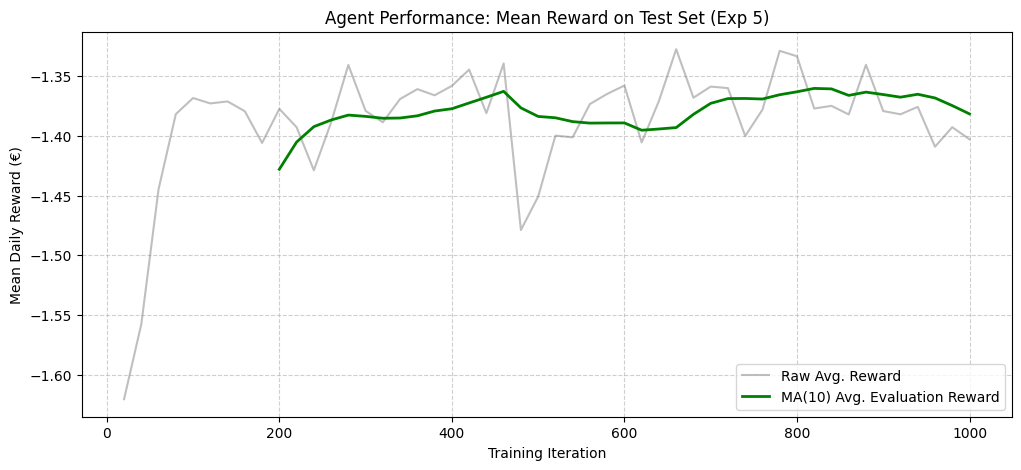

In [ ]:
import matplotlib.pyplot as plt
import json
import numpy as np

# --- Configure which experiment ID to load ---
# IMPORTANT: change this value to load a different experiment run
EXPERIMENT_ID_TO_LOAD = 5
# ---------------------------------------------

# Moving average helper for smoother visualization
def moving_average(x, w=20):
    """Compute a moving average over a window of size w."""
    x = np.array(x).flatten()
    if len(x) < w:
        return x
    return np.convolve(x, np.ones(w)/w, mode='valid')

# --- Load logs (JSON format) ---
REWARDS_FILE = f'rewards_log_exp{EXPERIMENT_ID_TO_LOAD}.json'

try:
    with open(REWARDS_FILE, 'r') as f:
        rewards_log = json.load(f)

    print(f"Training logs for Experiment {EXPERIMENT_ID_TO_LOAD} successfully loaded.")

except FileNotFoundError:
    print(f"ERROR: JSON log files for Experiment {EXPERIMENT_ID_TO_LOAD} were not found.")
    rewards_log = {'iteration': [], 'reward_mean': []}

def plot_training_results(rewards_history):
    """Display training metrics (without saving to disk)."""

    # Exit if no data is available
    if not rewards_history['iteration']:
        print("No data available to plot.")
        return

    # --- Plot: Mean evaluation reward (with moving average) ---
    plt.figure(figsize=(12, 5))
    rewards = rewards_history['reward_mean']
    iterations = rewards_history['iteration']
    ma_w = 10
    ma_rewards = moving_average(rewards, ma_w)
    ma_iterations = iterations[len(rewards) - len(ma_rewards):]

    plt.plot(iterations, rewards, label='Raw Avg. Reward', color='gray', alpha=0.5)
    plt.plot(ma_iterations, ma_rewards, label=f'MA({ma_w}) Avg. Evaluation Reward', color='green', linewidth=2)
    plt.title(f'Agent Performance: Mean Reward on Test Set (Exp {EXPERIMENT_ID_TO_LOAD})')
    plt.xlabel('Training Iteration')
    plt.ylabel('Mean Daily Reward (€)')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.show()

plot_training_results(rewards_log)

# **Conclusions**

Now you have everything you need to start training an effective agent.

To proceed further, you can change the hyperparameters, write new functions to keep track of the training process, and produce informative graphs that can help you understand what is going on behind the curtains of the model. \
To double check the code you just wrote, try to train and evaluate the agent on a single day (i.e., using the same data of 1 single day for both training and evaluation). This is a very simple task, hence your agent is supposed to behave well without too many difficulties. For example, try with day number 100. With that day, your agent should be able to achieve a daily total reward that is at least greater than -0.4 (when using a 4kW, 8kWh battery). \
Keep in mind that the algorithm will require some time to get trained. Don't give up on a parameter setting after only a bunch of minutes of training. Sometimes the agent might just need some extra episodes of training to start getting some sense of its actions.

**Your final agent needs to be saved using the methods we provided you. The agent you will upload will be evaluated on a private dataset taken out of the data we gave you, and the results will influence the score of your assignment.**

Whatever extra code you think you will need to train the agent, please write it below. \
**Moreover, we prepared a set of questions and tasks for you. These are part of your assignment evaluation.**

### **Question 0**

As explained before, we ask you to train your agent by working with normalize states, actions, and rewards by scaling their original value in more contained domain ([0, 1] or [-1, 1]). Can you reflect on this, giving your thoughts on why this should be (or should not be) done?

Write you brief considerations below:

---

Normalizing is advantageous because raw state components exhibit heterogeneous magnitudes. Feeding unscaled signals to the policy network biases optimization: features with large numeric ranges implicitly dominate gradient updates, even if they are not more relevant. Mapping each state dimension to a compact interval (for example [-1, 1]) mitigates this issue and stabilizes learning.

A second point is that the final activation of the policy network is typically a bounded nonlinearity (here for example tanh, which outputs strictly in [-1, 1]). This implies that the network inherently outputs “normalized” actions in the internal numeric space used for training. However the real environment expects physical actuation values in their native units and ranges. Therefore a de-normalization step is required after the forward pass to map the bounded network output to the actuator domain. Without this conversion the agent would not produce valid physical commands. For example, if the control variable for charging/discharging the battery ranges between [-0.5, 0.5] kW and the network outputs a normalized action of 1, this could exceed the actual capacity. Conversely, if the range were much larger than [-1, 1], the network might not fully utilize its capabilities.

Reward normalization follows the same logic: constraining reward magnitudes improves numerical conditioning and reduces target variance for the critic.

### **Question 1**
Coming out with good hyperparameters is not straightforward. Can you make a list below of the **most important** hyperparameters you had to choose to obtain better results? Give brief intuitions for each. If needed, you can back it up with evaluation results.

---

In general, we first defined a reasonable range for each hyperparameter and then optimized them one by one. Once we found the best estimate for a given parameter, we fixed it and proceeded to the next one using that configuration. The following are the parameters that most significantly influenced performance:

- Gamma: fixed at 0.99, as it determines the importance given to future rewards during training. Since the goal in this setting is to minimize costs over a long horizon, a high value of gamma encourages the agent to make short-term sacrifices when they lead to larger long-term savings (e.g., charging a bit more now, even if it costs slightly more, to avoid high peak prices later)

- Number of batches: fixed at 128. The batch size determines the number of days used for each rollout, so a higher number allows better generalization and helps prevent overfitting to specific days. In other words, it makes the agent more robust to the high stochasticity in PV production and consumption.

- Number of updates per iteration: fixed at 80. A value too low would cause the agent to learn too little from each rollout, slowing the learning process, while a value too high would lead to overfitting the sampled days. Empirically, we observed that the ratio of n_batches = 128 to updates_per_iteration = 80 yielded the best performance

- Actor and critic learning rates: fixed respectively at 1e-4 and 5e-4. These magnitudes were chosen to avoid large weight updates that could cause unstable learning. Furthermore, the critic learning rate was set higher than the actor’s, since the actor learns based on the critic’s output, and thus the critic should stabilize faster

- Sampling variance: fixed at 0.2. Given that the range of actions was [-1, 1], a higher value would have made the policy too stochastic. Empirically, this value proved high enough to ensure adequate exploration while remaining low enough to avoid completely random actions

- Clip value: fixed at 0.4. This is slightly wider than the 0.2 suggested in the original paper, allowing for more aggressive updates. The smooth learning curve confirmed that this value does not introduce instability


### **Question 2:**
When training an RL agent (or whatever Machine Learning model), a crucial step is to track the learning. Can you produce some informative graphs that tells you how is the training going? What observation can you draw from those?

Can you think of some other insightful graphs / information about the agent? For example, what kind of extra metric can you keep track of? Here are some examples:
- Probability ratio of the actions during training
- KL divergence of the policy before and after each training step

Briefly explain what you did and why here:

---

The first graph we chose to monitor shows the average evaluation reward, which allowed us to observe whether the agent was improving its energy management decisions and achieving higher performance as training progressed. As we can see, the mean reward improves from around -1.9 to -1.4 within just a few iterations and then after 100 iterations remains stable around that value. This indicates that the agent is optimizing energy usage efficiently.

Next, we monitored both the actor loss and the critic loss. From our graph, we can observe that the actor loss stabilizes after approximately 50 iterations, fluctuating between -0.014 and -0.04 without showing significant variations. The initial transient phase is expected, as the critic is not immediately stable, and consequently, the actor (which relies on the critic’s evaluations) also takes time to stabilize. However, we do not observe a clear descending trend, as one might expect from a loss function being minimized, even though the rewards continue to improve.
Regarding the critic loss, after the first few iterations it decreases and then stabilizes around zero.

Additionally, we plotted two PPO-specific metrics: the probability ratio (mean ± standard deviation) and the clip fraction. The probability ratio measures how much the new policy deviates from the old one during updates. In our case, the policy remains stable around a value of 1, showing that updates are small and consistent across iterations, a clear sign that the training process is stable. The clip fraction, on the other hand, stays low and even tends to decrease over time. Combined with the stable probability ratio, this explains why the policy updates remain well within the PPO trust region, ensuring that the learning process is neither too aggressive nor too conservative. This balance allows the energy management policy to improve smoothly and reliably over time.


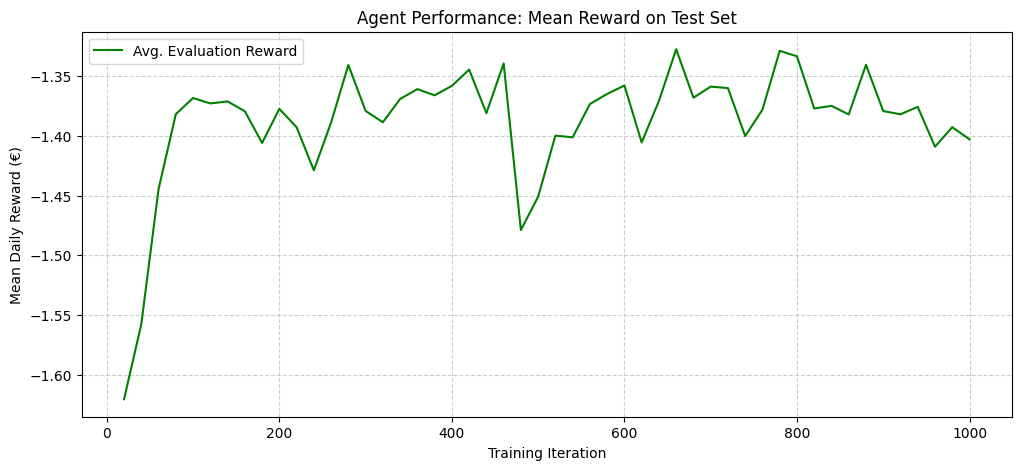

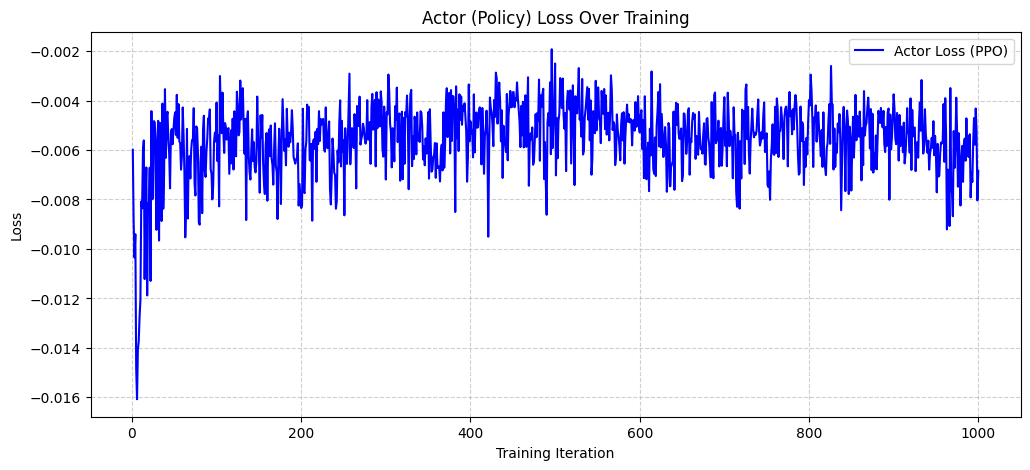

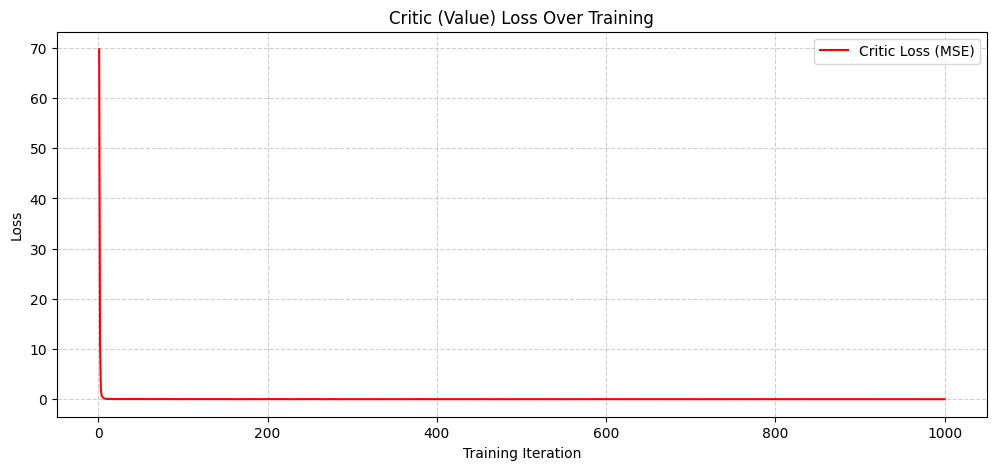

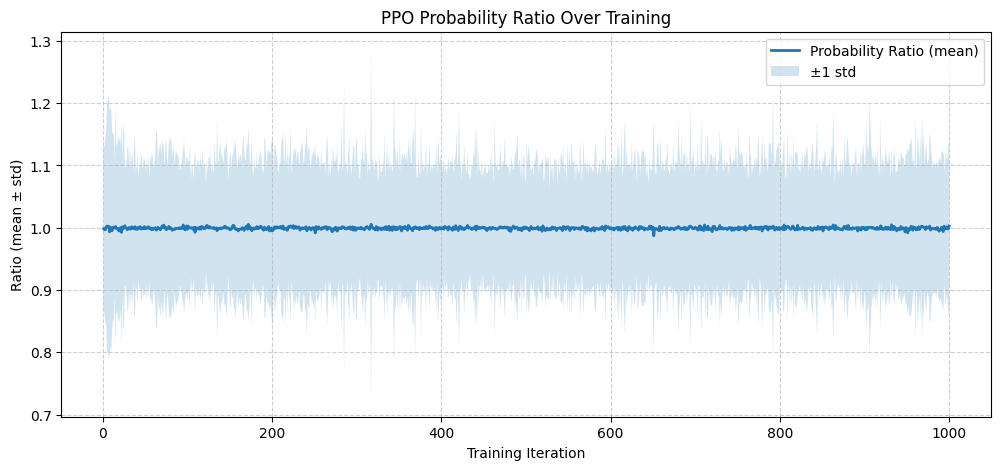

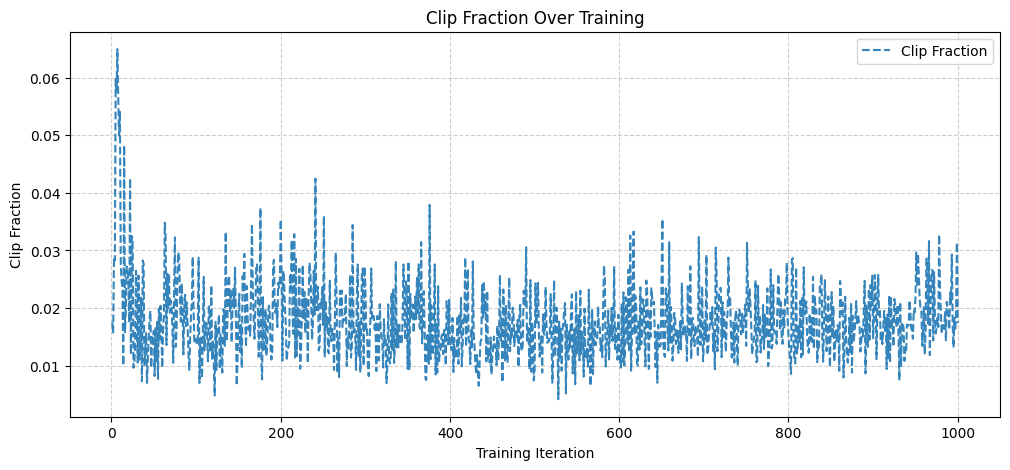

In [ ]:
# Training graphs

import matplotlib.pyplot as plt
import json
import numpy as np

SAVE_FIGS = False

EXPERIMENT_ID = EXPERIMENT_ID_TO_LOAD  # use same ID as defined in the plots before, change if needed

# --- Load stored logs (JSON) ---
with open(f'rewards_log_exp{EXPERIMENT_ID}.json', 'r') as f:
    rewards_log = json.load(f)
with open(f'actor_loss_log_exp{EXPERIMENT_ID}.json', 'r') as f:
    actor_loss_log = json.load(f)
with open(f'critic_loss_log_exp{EXPERIMENT_ID}.json', 'r') as f:
    critic_loss_log = json.load(f)

with open(f'ratio_log_exp{EXPERIMENT_ID}.json', 'r') as f:
    ratio_log = json.load(f)


def plot_training_results(rewards_history, actor_loss_history, critic_loss_history,
                          ratio_history=None):

    # mean evaluation reward
    plt.figure(figsize=(12, 5))
    plt.plot(rewards_history['iteration'], rewards_history['reward_mean'], label='Avg. Evaluation Reward', color='green')
    plt.title('Agent Performance: Mean Reward on Test Set')
    plt.xlabel('Training Iteration')
    plt.ylabel('Mean Daily Reward (€)')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    if SAVE_FIGS:
        plt.savefig('evaluation_reward.png'); plt.close()
    else:
        plt.show()

    # actor loss
    plt.figure(figsize=(12, 5))
    plt.plot(actor_loss_history['iteration'], actor_loss_history['loss'], label='Actor Loss (PPO)', color='blue')
    plt.title('Actor (Policy) Loss Over Training')
    plt.xlabel('Training Iteration')
    plt.ylabel('Loss')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    if SAVE_FIGS:
        plt.savefig('actor_loss.png'); plt.close()
    else:
        plt.show()

    # critic loss
    plt.figure(figsize=(12, 5))
    plt.plot(critic_loss_history['iteration'], critic_loss_history['loss'], label='Critic Loss (MSE)', color='red')
    plt.title('Critic (Value) Loss Over Training')
    plt.xlabel('Training Iteration')
    plt.ylabel('Loss')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    if SAVE_FIGS:
        plt.savefig('critic_loss.png'); plt.close()
    else:
        plt.show()

    # probability ratio (mean ± std)
    if ratio_history is not None and len(ratio_history.get('iteration', [])) > 0:
        it = ratio_history['iteration']
        r_mean = np.array(ratio_history['ratio_mean'])
        r_std  = np.array(ratio_history['ratio_std'])

        plt.figure(figsize=(12,5))
        plt.plot(it, r_mean, linewidth=2, label='Probability Ratio (mean)')
        plt.fill_between(it, r_mean - r_std, r_mean + r_std, alpha=0.2, label='±1 std')
        plt.title('PPO Probability Ratio Over Training')
        plt.xlabel('Training Iteration')
        plt.ylabel('Ratio (mean ± std)')
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.legend()

        if SAVE_FIGS:
            plt.savefig('ppo_ratio.png'); plt.close()
        else:
            plt.show()

    # clip fraction
    if ratio_history is not None and len(ratio_history.get('iteration', [])) > 0:
        it = ratio_history['iteration']
        clipf = ratio_history['clipfrac']

        plt.figure(figsize=(12,5))
        plt.plot(it, clipf, linestyle='--', alpha=0.9, label='Clip Fraction')
        plt.title('Clip Fraction Over Training')
        plt.xlabel('Training Iteration')
        plt.ylabel('Clip Fraction')
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.legend()

        if SAVE_FIGS:
            plt.savefig('ppo_clipfrac.png'); plt.close()
        else:
            plt.show()


plot_training_results(rewards_log, actor_loss_log, critic_loss_log, ratio_history=ratio_log)


### **Question 3:**

When using RL on a given problem, **you** also need to understand what the problem is about. Following that, it is important to keep track of the agent's performance by not only checking its numerical metrics (e.g., the obtained daily rewards), but also by checking if its actions make sense in the first place. To do so, plotting the policies obtained on a limited interval of time (e.g., a single day) is crucial. Can you write a function that does that? What observations / conclusions can you draw when you plot the agent policies?

Can you also think of additional way you can plot the policy without specifically referring to any specific day? In other words, can you generate a plot that describes the general behavior of the learnt policy in relation to some state inputs (not necessarily from the actual dataset; they could be artificially made just for the sake of the plot)?

Briefly explain your observations here:

---

Plotting the agent’s selected actions in a single day and comparing them with electricity price, load consumption, and photovoltaic production, we observe that the learned behavior is consistent with the task structure. The agent charges the battery when consumption is low and PV generation is high, and it discharges in the evening when demand increases and electricity prices rise. This indicates that the policy is not exploiting unintended shortcuts, and we did not observe reward hacking or anomalous behavior.

Beyond inspecting specific trajectories, we also visualized the policy in a more general way using a contour plot. In this analysis, we plotted the action magnitude as a function of battery SoC and electricity price while keeping the other variables (time in the day, PV production, Household consumption) fixed. This allows us to examine how the policy behaves in hypothetical regions of the state space, instead of relying only on states observed during real days in the dataset.

From different contour plots, obtained by varying the time and power variables, we concluded that our best agent is strongly time-dependent. For example, at around 22:00, it tends to discharge almost independently from the other state variables, while at 16:00 it strongly prefers to charge, preparing for the evening.
Moreover, the contours show that small perturbations in the state do not induce discontinuous changes in the selected action (given the smooth gradient of colours). This suggests that the policy is stable and smooth also outside of the exact states encountered during training, rather than being overfitted or brittle.


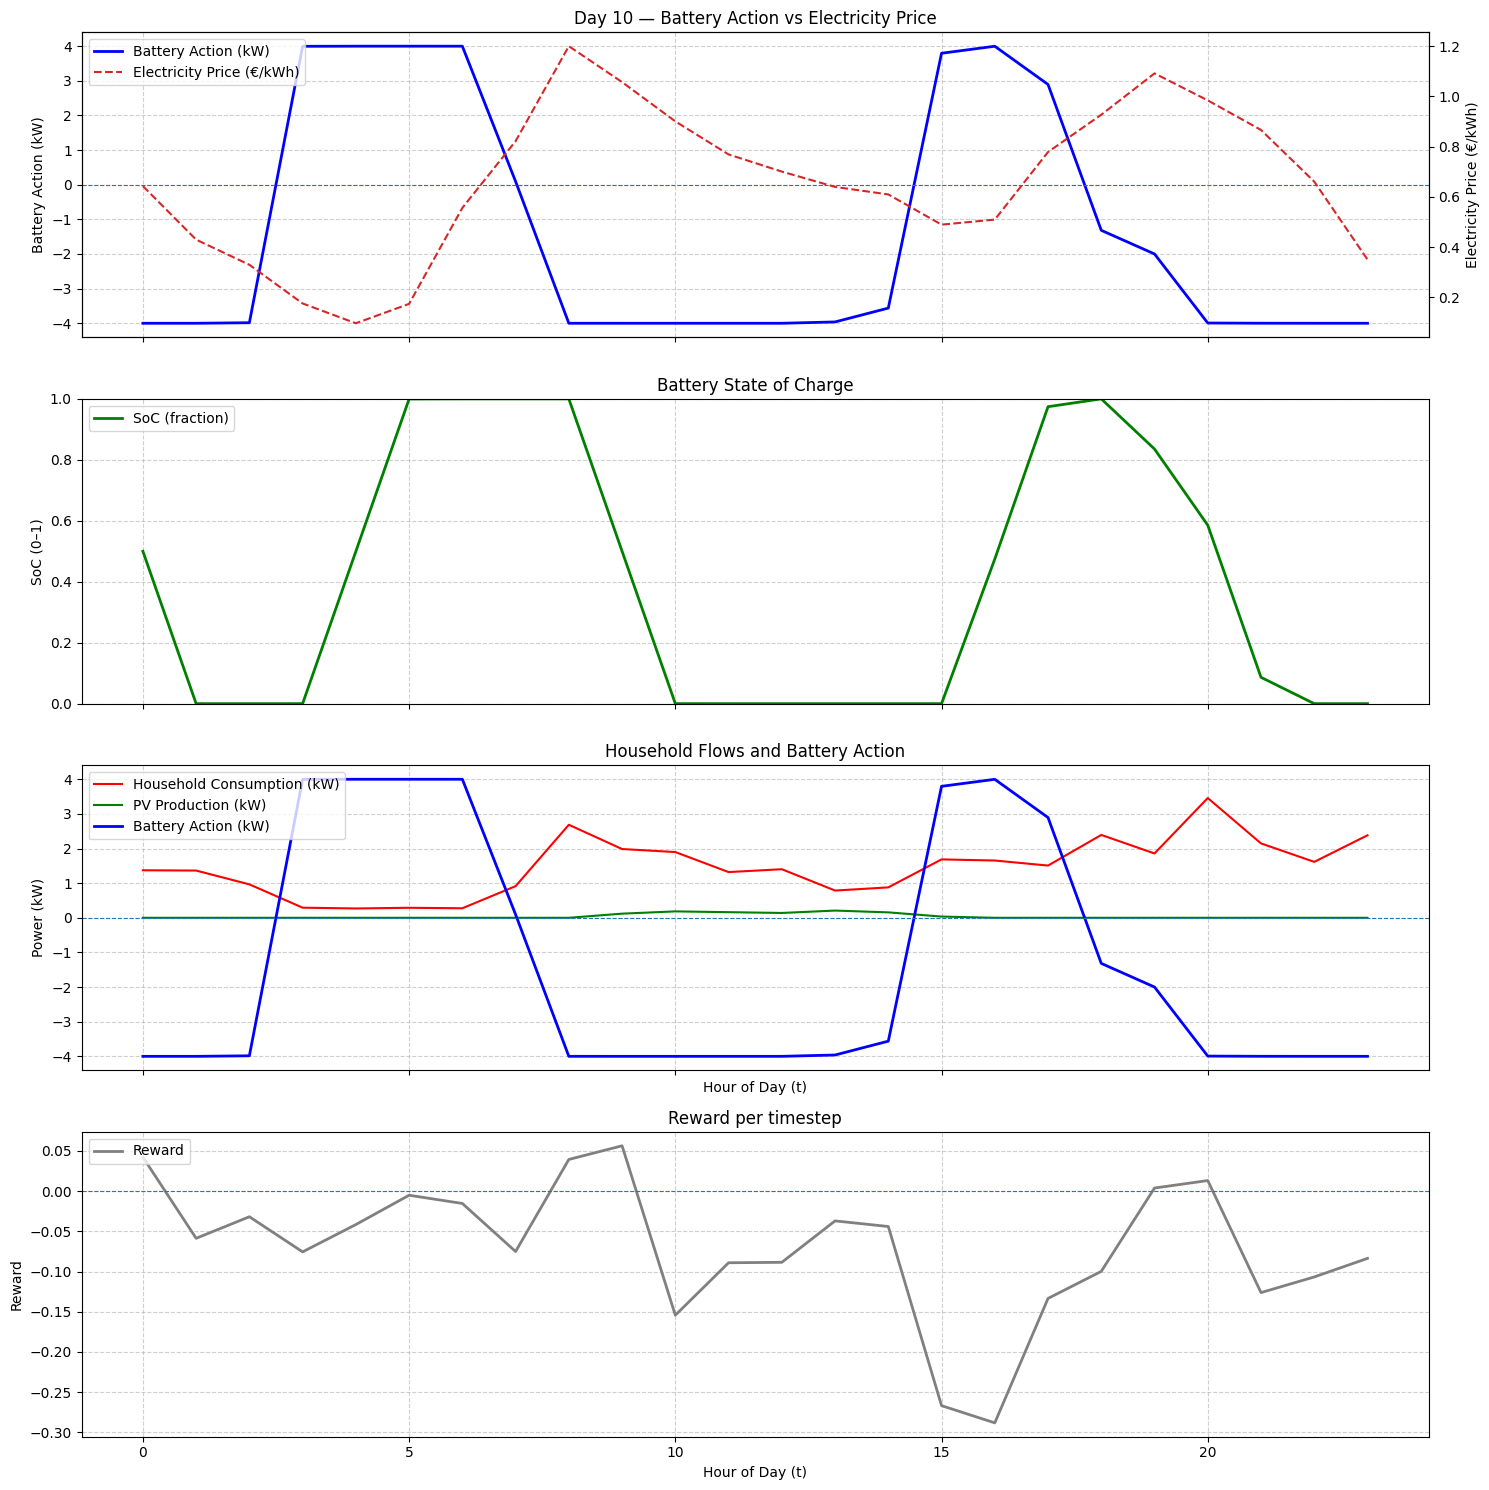

Total reward for day 10: -1.666


In [ ]:
# Policy visualization utilities
import matplotlib.pyplot as plt

def plot_policy_on_day(day_index: int):
    """
    Runs one full episode on the selected calendar day and visualizes:
      (1) Battery action vs electricity price (scaled)
      (2) State of Charge trajectory
      (3) Consumption + PV + battery action
      (4) Reward signal per timestep

    Actions are taken greedily (no exploration) in this evaluation mode.
    """

    ppo_agent.env.reset(day_index)

    t_list, price_list, pv_list, consumption_list, action_list, soc_list = [], [], [], [], [], []
    reward_list = []
    total_reward = 0.0

    state = ppo_agent.env.state
    done = ppo_agent.env.done

    # Run one episode and log relevant trajectories
    while not done:
        t, soc, price, pv, consumption = state

        act_tensor, _ = ppo_agent.sample_action(state, explore=False)
        act_phys = float(act_tensor)  # already in physical units

        next_state, reward, done, _ = ppo_agent.env.step(act_phys)

        t_list.append(t)
        price_list.append(price)
        pv_list.append(pv)
        consumption_list.append(consumption)
        action_list.append(act_phys)
        soc_list.append(soc)
        reward_list.append(float(reward))
        total_reward += float(reward)

        state = next_state

    fig, axes = plt.subplots(4, 1, figsize=(15, 15), sharex=True)

    # (1) Battery action (left y-axis) + scaled electricity price (right y-axis)
    axes[0].plot(t_list, action_list, label='Battery Action (kW)', linewidth=2, color='blue')
    axes[0].set_ylabel('Battery Action (kW)')
    axes[0].set_title(f'Day {day_index} — Battery Action vs Electricity Price')
    axes[0].axhline(0, linewidth=0.8, linestyle='--')
    axes[0].grid(True, linestyle='--', alpha=0.6)

    ax0b = axes[0].twinx()
    price_vis = [p * 10.0 for p in price_list]  # scaled only for visualization
    ax0b.plot(t_list, price_vis, label='Electricity Price (€/kWh)', linestyle='--', color='tab:red')
    ax0b.set_ylabel('Electricity Price (€/kWh)')

    # Legend (filtered to avoid internal matplotlib labels)
    lines_left  = [l for l in axes[0].get_lines() if l.get_label() and not l.get_label().startswith('_')]
    lines_right = [l for l in ax0b.get_lines()    if l.get_label() and not l.get_label().startswith('_')]
    all_lines   = lines_left + lines_right
    axes[0].legend(all_lines, [l.get_label() for l in all_lines], loc='upper left')


    # (2) SoC trajectory
    axes[1].plot(t_list, soc_list, label='SoC (fraction)', linewidth=2, color='green')
    axes[1].set_ylabel('SoC (0–1)')
    axes[1].set_title('Battery State of Charge')
    axes[1].set_ylim(0, 1)
    axes[1].grid(True, linestyle='--', alpha=0.6)
    axes[1].legend(loc='upper left')

    # (3) Energy flows (PV, consumption, action)
    axes[2].plot(t_list, consumption_list, label='Household Consumption (kW)', color='red')
    axes[2].plot(t_list, pv_list, label='PV Production (kW)', color='green')
    axes[2].plot(t_list, action_list, label='Battery Action (kW)', linewidth=2, color='blue')
    axes[2].axhline(0, linewidth=0.8, linestyle='--')
    axes[2].set_ylabel('Power (kW)')
    axes[2].set_xlabel('Hour of Day (t)')
    axes[2].set_title('Household Flows and Battery Action')
    axes[2].grid(True, linestyle='--', alpha=0.6)
    axes[2].legend(loc='upper left')

    # (4) Reward signal
    axes[3].plot(t_list, reward_list, label='Reward', linewidth=2, color='gray')
    axes[3].axhline(0, linewidth=0.8, linestyle='--')
    axes[3].set_ylabel('Reward')
    axes[3].set_xlabel('Hour of Day (t)')
    axes[3].set_title('Reward per timestep')
    axes[3].grid(True, linestyle='--', alpha=0.6)
    axes[3].legend(loc='upper left')

    plt.tight_layout()
    plt.show()

    print(f"Total reward for day {day_index}: {total_reward:.3f}")

# Example:
ppo_agent.load_agent()  # Load the best actor saved in "actor.pickle"
plot_policy_on_day(day_index=10)

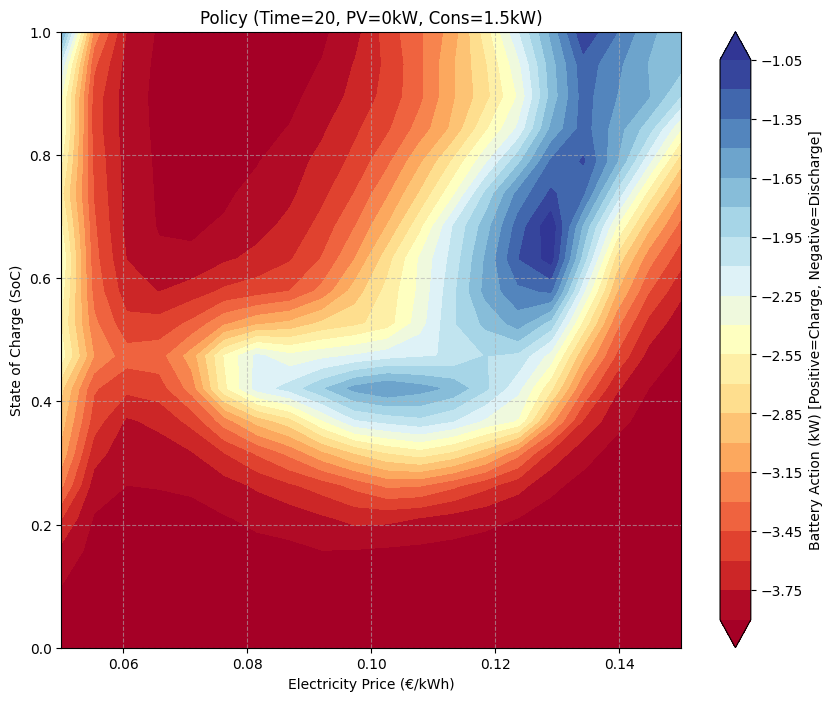

In [ ]:
def plot_generic_policy_contour(fixed_time=12, fixed_pv=1.0, fixed_consumption=0.5):
    """
    Plot the greedy action (Z-axis) as a function of Price (X-axis) and SoC (Y-axis),
    keeping the remaining state components fixed.
    """

    # Input ranges for the grid
    soc_range   = np.linspace(0.0, 1.0, 20)
    price_range = np.linspace(0.05, 0.15, 20)

    SoC_mesh, Price_mesh = np.meshgrid(soc_range, price_range)
    Action_mesh = np.zeros_like(SoC_mesh, dtype=np.float32)

    # Put the actor in eval mode for clean inference (no dropout/batchnorm updates)
    import torch
    prev_training = ppo_agent.actor.training
    ppo_agent.actor.eval()

    with torch.no_grad():
        for i in range(len(price_range)):
            for j in range(len(soc_range)):
                state_data = np.array(
                    [fixed_time, SoC_mesh[i, j], Price_mesh[i, j], fixed_pv, fixed_consumption],
                    dtype=np.float32
                )

                # sample_action expects the RAW state (do NOT pre-scale here)
                action_phys_t, _ = ppo_agent.sample_action(state_data, explore=False)
                Action_mesh[i, j] = float(action_phys_t)

    # Restore original training mode if it was enabled
    if prev_training:
        ppo_agent.actor.train()

    plt.figure(figsize=(10, 8))
    contour = plt.contourf(Price_mesh, SoC_mesh, Action_mesh, levels=20, cmap='RdYlBu', extend='both')
    plt.colorbar(contour, label='Battery Action (kW) [Positive=Charge, Negative=Discharge]')
    plt.title(f'Policy (Time={fixed_time}, PV={fixed_pv}kW, Cons={fixed_consumption}kW)')
    plt.xlabel('Electricity Price (€/kWh)')
    plt.ylabel('State of Charge (SoC)')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

# Example:
ppo_agent.load_agent()  # Load the best actor saved in "actor.pickle"
plot_generic_policy_contour(fixed_time=20, fixed_pv=0, fixed_consumption=1.5)

### **Question 4.1:**

PPO stands in the RL algorithm family of policy gradients methods. These differ from value-based methods such as Deep Q-Network (DQN) in the way the agent obtain the actions.
Policy gradient methods have an actor model that directly returns an action after processing an input state. In value-based methods, instead, the actor processes the input state to approximate the Q-function (or the value function) of the problem; the action is then selected based on the approximated Q-function values (for example by argmaxing each Q values). \
Specifically thinking about this problem (home energy management), can you reflect on what major advantages/disadvantages one algorithmic family brings over the other?

Briefly explain your observations here:

---

Policy gradient algorithms have the advantage of being able to handle continuous action spaces, which is particularly suitable in this context, where the agent’s decisions, such as adjusting the power of a heater or the charge level of a battery are not discrete choices but real-valued, smoothly varying actions. This allows for more regular and stable control. Moreover, since PPO learns a stochastic policy, it helps the agent explore the environment more efficiently, which might be useful in scenarios like energy management, where conditions can change over time. However, PPO requires a large number of interactions with the environment to achieve good performance and is quite sensitive to the choice of hyperparameters.

On the other hand, value-based algorithms such as DQN can be simpler to train and more sample-efficient. However, they work best when actions are discrete, and in a context like this, it would be necessary to discretize the continuous actions, thus losing precision.

### **Question 4.2:**

In this assignment, you used 2 neural networks as models for both the critic and actor. This is a choice we made when designing this assignment, but it is not mandatory. Other regression architectures/models could have been used. Can you think of any specific reason why we would want to use a different model?  Write some considerations regarding this, with specific focus on the actor model.

Briefly explain your observations here:

---

Traditional neural networks are often treated as black-box models, making it difficult to interpret why the actor selects specific actions. In some contexts, however, understanding the reasoning behind the policy is essential. For instance, decision tree–based policies can be directly inspected, allowing the decision rules to be clearly visualized and explained.

Another alternative would be to use linear regression models. Their main advantage lies in their high interpretability: the battery action would simply be a linear combination of the state variables, and the learned weights would directly indicate how strongly and in what direction each variable influences the charge or discharge decision.

Linear models are also extremely lightweight, requiring minimal computational resources for inference. This makes them well-suited for deployment on resource-constrained devices, such as small microcontrollers or home IoT gateways. Compared to large neural networks with thousands of neurons (which require significant computational power for both training and inference), linear models can drastically reduce computational load and speed up both training and deployment. However, this simplicity comes at the cost of limited expressive power, as they struggle to capture the complex non-linear relationships typically present in real-world energy optimization problems.


### **Question 5:**

One of the benefits of implementing an algorithm from scratch (besides the obvious one of understanding more deeply what the algorithm is about) is the total control over the code you just wrote. This enables you to customize your code to, for example, gain informative insights regarding the algorithm dynamics.
There are a few things you can implement in your PPO code to potentially improve its performance. Here we give you some suggestions, but feel free to also check online sources to take additional inspiration.
- Entropy regularization
- Generalized Advantage Estimation (check [paper](https://arxiv.org/pdf/1506.02438))
- Learnable sampling variance
- Mini-batch partition fo the rollout data when training
- Learning Rate Annealing

Can you implement some of these additional features and report their value over the agent training phase? You do not have to implement them all, but even if you do, **please report only 1 or 2 of them**. \
Make a complete report of what differences you noticed using or not using the additional feature you implemented. Consider it as a mini scientific report.

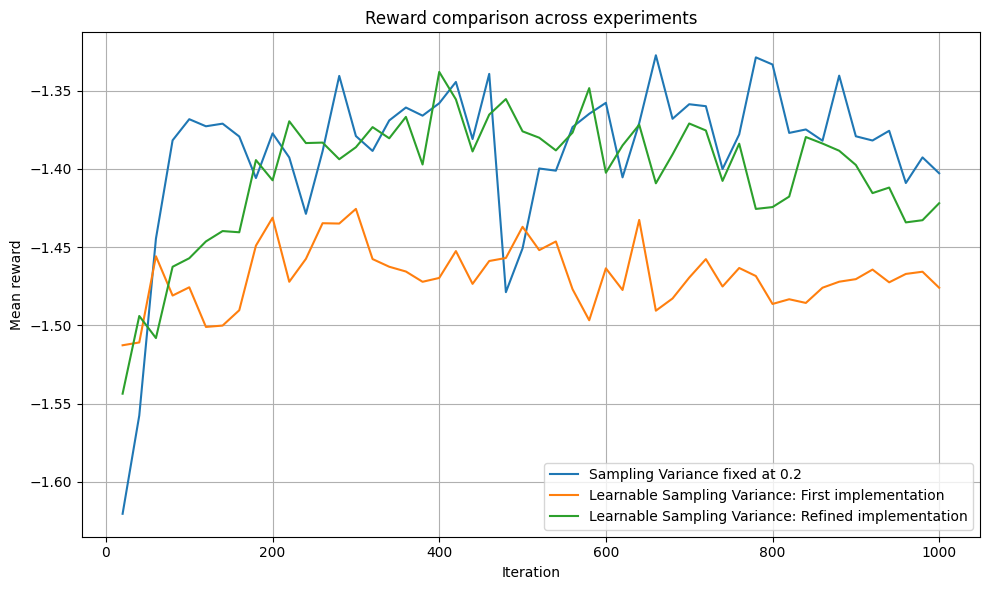

In [ ]:
import json
import matplotlib.pyplot as plt

# Experiment IDs to compare (JSON file names are rewards_log_exp{ID}.json)
exp_ids = [5, 3, 2]

# Labels to show in the legend (same length and order as exp_ids)
labels = [
    "Sampling Variance fixed at 0.2",
    "Learnable Sampling Variance: First implementation",
    "Learnable Sampling Variance: Refined implementation",
]

rewards_dict = {}
x_values = None

for exp_id, label in zip(exp_ids, labels):
    filename = f"rewards_log_exp{exp_id}.json"

    # Load JSON log and extract arrays
    with open(filename, "r") as f:
        data = json.load(f)

    iterations = data["iteration"]
    reward_mean = data["reward_mean"]

    if x_values is None:
        x_values = iterations

    rewards_dict[label] = reward_mean

# Plot all experiments in a single figure
plt.figure(figsize=(10, 6))

for label, rewards in rewards_dict.items():
    plt.plot(x_values, rewards, label=label)

plt.xlabel("Iteration")
plt.ylabel("Mean reward")
plt.title("Reward comparison across experiments")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Entropy regularization

Entropy Regularization is a technique used in policy gradient methods, such as PPO, to encourage exploration during training. It involves adding a term to the agent’s objective function that is proportional to the entropy of the policy’s action distribution.

The entropy term is incorporated directly into the Actor’s loss function. Since the base PPO objective aims to maximize the expected return, the entropy term is added to promote higher entropy (i.e., more randomness and exploration in the policy’s behavior). In this case, the coefficient β=0.015 was chosen carefully: not too large to risk destabilizing training, but sufficient to encourage exploratory behavior.

This mechanism is particularly useful in complex environments, where an agent’s policy can quickly become deterministic, limiting its ability to discover better actions. By maintaining a certain degree of randomness, the agent can avoid getting trapped in suboptimal local minima.

However, in this specific problem, adding Entropy Regularization did not lead to performance improvements. This is likely because the PPO algorithm already includes inherent exploration through its stochastic policy and well-tuned sampling variance. The baseline stochasticity, combined with large rollouts across multiple diverse days, appears sufficient to prevent the policy from getting stuck in poor local optima. In this context, forcing additional randomness through the entropy term may actually slow convergence, resulting in a slightly higher daily cost.

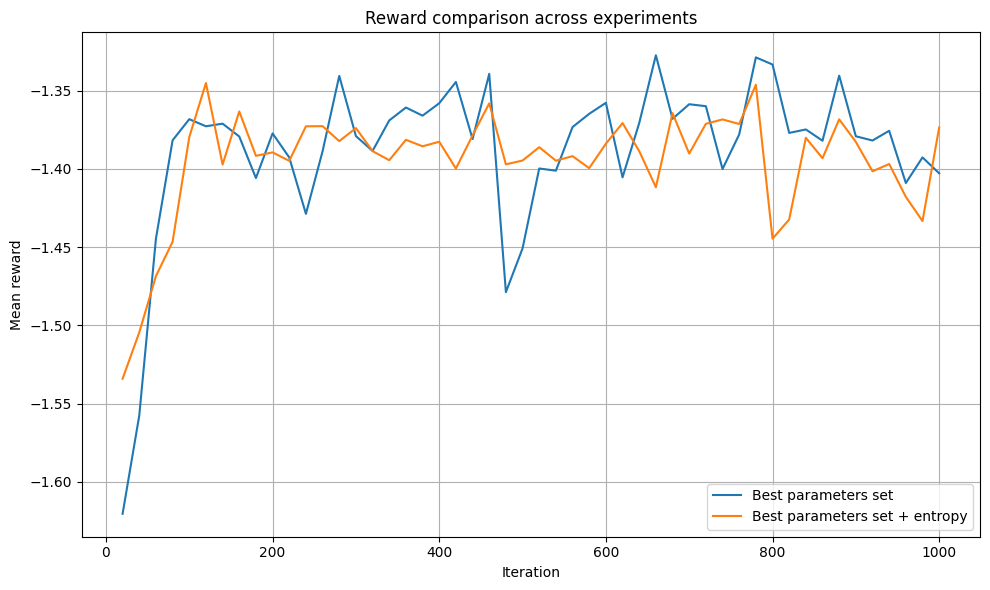




## Learnable Sampling Variance

#### Initial implementation

We replaced the fixed sampling variance with a learnable, state-independent parameter `log_std`, defined as an `nn.Parameter`. The stochastic policy was modeled as a Gaussian with mean given by the actor network and standard deviation `std = exp(log_std)`, so that `log_std` is unconstrained while `std` is guaranteed positive. The `log_std` parameter was optimized jointly with the actor using the same learning rate. This configuration resulted in performance clearly worse than the baseline with fixed variance `0.2`.

#### Refined implementation: decoupled learning rate and clamping

In a second step, we tried decoupling the learning rate of the variance from the actor parameters, introducing a dedicated hyperparameter for `log_std`, set to `1e-5` (ten times smaller than the actor learning rate). Furthermore, we constrained `log_std` such that the corresponding standard deviation is clamped between `0.05` and `0.9`. This was intended to lead on a more controlled adaptation of the sampling variance. The refined version produced better results than the initial learnable-variance implementation, although still slightly below the fixed-variance (`0.2`) baseline.

Interestingly, in this refined configuration the evaluation reward shows a slight decrease after approximately 400–500 iterations. This could simply be random oscillation, but it may also be a symptom of mild overfitting, since an additional trainable parameter has been introduced into the model.

The overall behaviour of the reward curves is shown in the plot below:





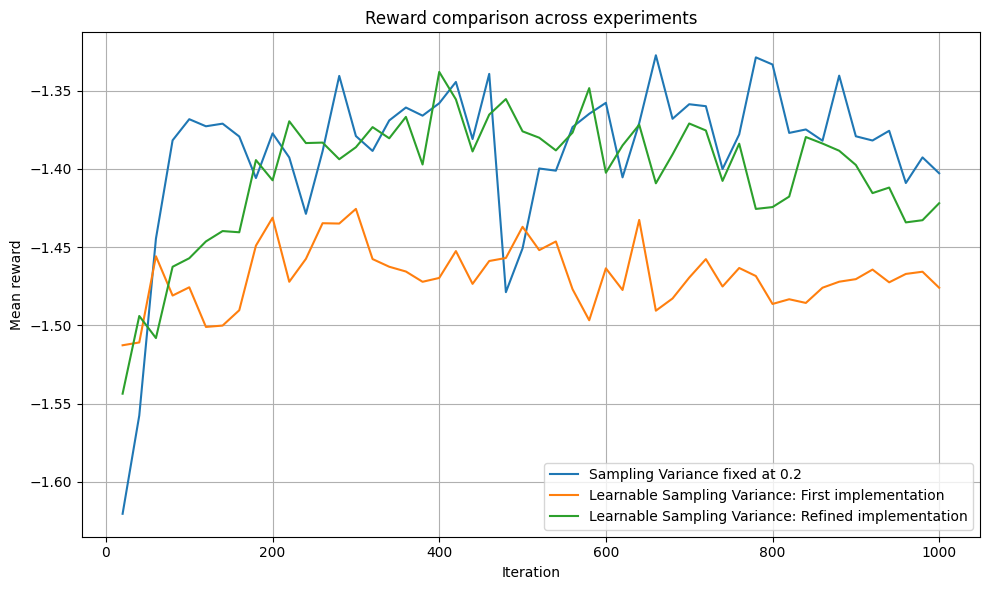
